<a href="https://colab.research.google.com/github/mbibrahe/BA_Project/blob/main/DBSCAN_bgSub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()


Cloning into 'CDnet2014'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [2]:
#!ls */train/*

In [3]:
from __future__ import print_function
import glob, os, numpy as np
from keras.preprocessing import image as kImage
from __future__ import print_function
import numpy as np
import random as rn
import os
from tensorflow.compat.v1.keras import backend as K




In [4]:
''
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [5]:

"""download = drive.CreateFile({'id': '1MUOVUdNCDTHA0FuHo4IsONhxSLLMxdZ7'})
download.GetContentFile("a2_n.zip")"""

#from google.colab import drive
#drive.mount ('/content/drive')

download = drive.CreateFile({'id': '1GEdqDLbRKanauCvHIwTMDp5h5iBmWFdj'})
download.GetContentFile("Full_test1.zip")


#! unzip a2_n.zip
! unzip Full_test1.zip

Archive:  Full_test1.zip
   creating: Full_test1/test/
   creating: Full_test1/test/x/
  inflating: Full_test1/test/x/1_in000595.jpg  
  inflating: Full_test1/test/x/1_in000604.jpg  
  inflating: Full_test1/test/x/1_in000613.jpg  
  inflating: Full_test1/test/x/1_in000622.jpg  
  inflating: Full_test1/test/x/1_in000631.jpg  
  inflating: Full_test1/test/x/1_in000640.jpg  
  inflating: Full_test1/test/x/1_in000649.jpg  
  inflating: Full_test1/test/x/2_in000460.jpg  
  inflating: Full_test1/test/x/2_in000469.jpg  
  inflating: Full_test1/test/x/2_in000478.jpg  
  inflating: Full_test1/test/x/2_in000487.jpg  
  inflating: Full_test1/test/x/2_in000496.jpg  
  inflating: Full_test1/test/x/2_in000505.jpg  
  inflating: Full_test1/test/x/3_in000994.jpg  
  inflating: Full_test1/test/x/3_in001003.jpg  
  inflating: Full_test1/test/x/3_in001012.jpg  
  inflating: Full_test1/test/x/3_in001021.jpg  
  inflating: Full_test1/test/x/3_in001030.jpg  
  inflating: Full_test1/test/x/in000700.jpg  
  i

In [6]:
import numpy as np

import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling3D
from keras.models import Sequential
from keras.layers.convolutional import Deconv2D, Conv2DTranspose
from keras.layers import Activation, Input, Dropout, BatchNormalization, SpatialDropout2D, LayerNormalization
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf
from keras import regularizers
from PIL import Image as PILimage
import matplotlib.pyplot as plt
from matplotlib import image as imageMat
from keras import backend as K
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image as Image
from sklearn.datasets import load_sample_image
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import cv2 as cv


import sys, time

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS

# Load images into array as graycale 320*240
dataset_path = os.path.join('Full_test1')
def getData(dataset_dir):
    X_list1= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','1','*.jpg')))
    X_list2= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','2','*.jpg')))
    X_list3= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','3','*.jpg')))
    X_list4= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','4','*.jpg')))
    X_list5= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','5','*.jpg')))
    X_list6= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','6','*.jpg')))
    X_list7= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','7','*.jpg')))
    X_list8= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','8','*.jpg')))
    X_list9= sorted(glob.glob(os.path.join(dataset_dir, 'train', 'x','9','*.jpg')))

    X_gray= []
    X= []



    #Run for less frames
    for i in range(len(X_list1)-1):
        # Load input image
        
        x_gray = cv.resize(cv.imread(X_list1[i], 0), (320, 240))
        x_gray = cv.normalize(x_gray, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        X_gray.append(x_gray)



        x = cv.resize(cv.imread(X_list1[i]), (320, 240))
        normalizedImg = np.zeros((320, 240))
        normalizedImg = cv.normalize(x,  normalizedImg, 0, 255, cv.NORM_MINMAX)
        X.append(normalizedImg)

    X_gray = np.asarray(X_gray)
    X = np.asarray(X)

    return X_gray, X

X_gray, X = getData(dataset_path)

print(X_gray[0].shape)

(240, 320)


In [16]:

import heapq
import statistics
from collections import Counter

def nn_epsilon(frames):

  #We find the optimal value for epsilon, using k-nearest neighbor.
  #Reshaping (flattening) the grayscale 3d array, into a 2d array
  nsamples, nx, ny = frames.shape
  d2_X = frames.reshape((nsamples,nx*ny))
  #print(d2_X.shape)
  temp_ = []

  #We find the nearest 2 neighbors for each pixel in the same frame.
  #Returns the 2 indices of the nearest 2 neighbors, aswell as the euclidean distance (in a straight line) to those neighbors.
  #We run for n frames, appending the max euclidean distances to the 2nd neighbor (the neighbor which is not itself)
  for i in range(len(frames)):

    nbrs = NearestNeighbors(n_neighbors=2).fit(frames[i])
    distances, indices = nbrs.kneighbors(frames[i])
    #print(distances, indices)

    distances = distances[:,1]
    
    temp_.append(max(distances))
  temp_arr = np.array(temp_)
  #We sort the average euclidean distances in ascending order 
  temp_arr = np.sort(temp_arr, axis=0)
  

  #We approach the point of maximum curvature (elbow)
  ####### IS THIS NECESSARY ########## 
  dif_ = [j-i for i, j in zip(temp_arr[:-1], temp_arr[1:])]

  #Zip original distances with dif_, and find the distance with largest dif_
  avg_dif = sum(dif_)/len(dif_)
  n_zip = zip(temp_arr, dif_)
  tip_ = []
  for x, y in n_zip:
    if (y > avg_dif):
      tip_.append(x)
  #print(len(tip_))
  list_of_max = heapq.nlargest(round(len(tip_)/2), tip_)
  avg_max_dif = sum(list_of_max)/len(list_of_max)
  
  
  #plt.plot(temp_arr)
  #plt.show()
  return avg_max_dif
nn_epsilon(X_gray)



#Epsilon is the maximum distance between to samples, for them to be clustered in the same neighborhood
#Min_samples is the minimum number of samples in a neighborhood for a data point to qualify as a core point 
#Frames = out dataset, eps = the optimal calculated epsilon, minPts = dataset dim*2
def fix_photo(frames, grey_frames, eps=5.75, minPts = 6):
    eps_ = nn_epsilon(grey_frames)
    shape = (len(frames), len(frames[0]), len(frames[0][0]))
    print("shape1 = " + str(len(shape[1])))
    image = []

    bar_width = 40
    bar_prog = 0
    start = time.time()
    
    sys.stdout.write("Running DBSCAN...\nProgress: 0/" + str(shape[1]) + " [" + (bar_width * " ") + "] ETA: N/A")
    sys.stdout.flush()
    #iterate through rows
    for r in range(0, shape[1]):
        row = []
        #iterate through cols
        for c in range(0, shape[2]):

            #Create temp array of current r, c pixel for EVERY frame in the original video.
            #This means, we create an array of length 200, where each element is the rgb values, 
            #for pixel at location 1,1, then at location 1,2 and so on.
            pixels = np.array([frame[r][c] for frame in frames])
            print(pixels)
            
            # Compute the means
            
            db = DBSCAN(eps_, min_samples=minPts).fit(pixels)

            
            
            # Grab label information.
            labels = db.labels_
            #print(Counter(labels))
            label_set = set(labels)
            label_count = {l : 0 for l in label_set}
            
            # Compute label frequency
            for l in labels:
                label_count[l] += 1
            
            # Choose a cluster.
            choice = None
            for l in label_set:
                if choice is None or label_count[choice] < label_count[l] and l != -1:
                    choice = l
            
            # Apply the pixel if it exists.
            if choice is None:
                row.append(np.mean(pixels, axis=0))
            else:
                row.append(np.mean(np.array([pixels[i] for i in range(len(labels)) if labels[i] == choice]), axis=0))
                   
        # Provide the image
        image.append(row)
        
        # Bar progress
        bar_prog = int((bar_width * (r+1.)) / shape[1])
        
        # Time remaining
        t = time.time() - start
        t = (shape[1] * t / (r+1.0)) - t

        sys.stdout.write("\rProgress: " + str(r+1) + "/" + str(shape[1]) + " [" + ("#" * bar_prog) + (" " * (bar_width - bar_prog)) + "] ETA: ")
        sys.stdout.write(time.strftime("%H hr %M min", time.gmtime(t)))
        sys.stdout.flush()

    sys.stdout.write("\rProgress: " + str(shape[1]) + "/" + str(shape[1]) + " [" + ("#" * bar_prog) + (" " * (bar_width - bar_prog)) + "] Done! ")

    print(time.strftime("(Time: %H hr %M min)", time.gmtime(time.time() - start)))

    return image



res = np.array(fix_photo(X, X_gray)).astype(np.uint8)





shape1 = 240
Running DBSCAN...
Progress: 0/240 [                                        ] ETA: N/A[[ 85 100  86]
 [ 77 100  85]
 [ 77 100  85]
 [ 77 100  86]
 [ 77 100  85]
 [ 76  99  85]
 [ 75  98  84]
 [ 79  97  84]
 [ 77 100  86]
 [ 76  99  84]
 [ 80  99  84]
 [ 76  99  85]
 [ 77 100  86]
 [ 77 100  86]
 [ 73  96  81]
 [ 76  99  85]
 [ 78 101  86]
 [ 82 101  86]
 [ 74  97  83]
 [ 76  99  85]
 [ 76  99  85]
 [ 76  99  85]
 [ 76  99  85]
 [ 80  99  84]
 [ 76  99  84]
 [ 78 101  87]
 [ 81  99  86]
 [ 75  98  84]
 [ 77 100  86]
 [ 77 100  85]
 [ 78 101  87]
 [ 78 101  87]
 [ 80 103  88]
 [ 78 101  86]
 [ 80 103  89]
 [ 78 101  86]
 [ 78 101  86]
 [ 79 102  87]
 [ 82 105  91]
 [ 81 104  90]
 [ 82 105  90]
 [ 84 107  92]
 [ 81 104  89]
 [ 82 105  90]
 [ 87 106  91]
 [ 83 106  91]
 [ 82 105  90]
 [ 81 104  89]
 [ 81 104  89]
 [ 81 104  89]
 [ 81 104  89]
 [ 83 106  91]
 [ 80 103  88]
 [ 80 103  88]
 [ 81 104  89]
 [ 81 104  90]
 [ 81 104  89]
 [ 81 104  89]
 [ 83 106  92]
 [ 82 105  91]
 [

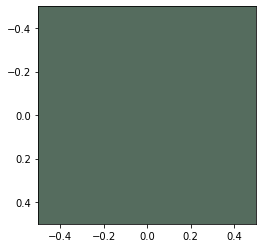

In [11]:
plt.imshow(res)
plt.show()

In [ ]:
#cv.imwrite ('/content/drive/My Drive/bg9.jpg', res)